# Final Project

**Due date: Saturday, December 9th**

For your final project you will develop a data narrative with a dataset of your choosing. Your data can come from any source. You do not have to comprehensively explore your data. Pick an interesting aspect or two from which to build your narrative.

## Requirements

- At least **three** visualizations. Visualizations can be simple bar charts that total data categories or rich exploratory figures. (*Tables also count as visualizations but you must have at least two charts.*) 
- All of the code should be recorded in your narrative. That is, I should be able to run your notebook code start to finish re-producing each of your outputs without error.
- At least **two** but no more than **three** paragraphs walking the reader through your analysis.
- Charts should exhibit your command of `ggplot2/dplyr/forcats/tidyr` with: 
  - sensibly sorted categories, 
  - interpretable labels/axis titles, 
  - useful annotations (when applicable), 
  - adjustments to default chart aesthetics, 
  - appropriate markings (e.g. `geoms`) and encodings.

## Notes

*This project should not take you longer than the time to complete two of our assignments. It is meant to demonstrate that you can build an analysis using `R` and the `Tidyverse` from scratch. Focus your analysis on a small number of data features that you find interesting.*

*Remember all the ways of visualizing distributions (ECDFs, histograms, jitter-ed scatter plots, etc.). These will come in very handy!* 

In [1]:
library(tidyverse)
library(dplyr)

Warning message:
“Failed to locate timezone database”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
age_gaps <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-02-14/age_gaps.csv')

Rows: 1155 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): movie_name, director, actor_1_name, actor_2_name, character_1_gend...
dbl  (5): release_year, age_difference, couple_number, actor_1_age, actor_2_age
date (2): actor_1_birthdate, actor_2_birthdate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
age_gaps |> head()

movie_name,release_year,director,age_difference,couple_number,actor_1_name,actor_2_name,character_1_gender,character_2_gender,actor_1_birthdate,actor_2_birthdate,actor_1_age,actor_2_age
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>,<date>,<dbl>,<dbl>
Harold and Maude,1971,Hal Ashby,52,1,Ruth Gordon,Bud Cort,woman,man,1896-10-30,1948-03-29,75,23
Venus,2006,Roger Michell,50,1,Peter O'Toole,Jodie Whittaker,man,woman,1932-08-02,1982-06-03,74,24
The Quiet American,2002,Phillip Noyce,49,1,Michael Caine,Do Thi Hai Yen,man,woman,1933-03-14,1982-10-01,69,20
The Big Lebowski,1998,Joel Coen,45,1,David Huddleston,Tara Reid,man,woman,1930-09-17,1975-11-08,68,23
Beginners,2010,Mike Mills,43,1,Christopher Plummer,Goran Visnjic,man,man,1929-12-13,1972-09-09,81,38
Poison Ivy,1992,Katt Shea,42,1,Tom Skerritt,Drew Barrymore,man,woman,1933-08-25,1975-02-22,59,17


In [4]:
install.packages('here')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [5]:
install.packages('janitor')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Note: The code below was provided by tidytuesday to clean the data.

In [7]:
library(here)
library(janitor)

age_gaps <- read_csv(
  "http://hollywoodagegap.com/movies.csv",
) |> 
  clean_names()

glimpse(age_gaps)

# Quickly check that the columns make sense.
length(vctrs::vec_cast(age_gaps$release_year, integer())) == nrow(age_gaps)
length(vctrs::vec_cast(age_gaps$age_difference, integer())) == nrow(age_gaps)
unique(age_gaps$actor_1_gender)
!any(is.na(as.Date(age_gaps$actor_1_birthdate)))
length(vctrs::vec_cast(age_gaps$actor_1_age, integer())) == nrow(age_gaps)
unique(age_gaps$actor_2_gender)
!any(is.na(as.Date(age_gaps$actor_2_birthdate)))
length(vctrs::vec_cast(age_gaps$actor_2_age, integer())) == nrow(age_gaps)

# Formally set the dates to dates.
age_gaps <- age_gaps |> 
  mutate(
    across(
      ends_with("birthdate"),
      as.Date
    )
  )

# Try to get a better understanding of the "gender" columns.
count(age_gaps, actor_1_gender)
count(age_gaps, actor_2_gender)

# The order of the characters doesn't seem to be consistent
age_gaps |> 
  summarize(
    p_1_older = mean(actor_1_age > actor_2_age),
    p_1_male = mean(actor_1_gender == "man"),
    p_1_female_2_male = mean(actor_1_gender == "woman" & actor_2_gender == "man"),
    p_1_first_alpha = mean(actor_1_name < actor_2_name)
  )

# For the most part, they put the man first if there's a man in the couple. It
# doesn't look like there's a strict rule, though. But beware: Some movies have
# more than 1 couple! Let's use all that to rebuild the data, always putting the
# older character first.
age_gaps <- age_gaps |> 
  mutate(
    couple_number = row_number(),
    .by = "movie_name"
  ) |> 
  pivot_longer(
    cols = starts_with(c("actor_1_", "actor_2_")),
    names_to = c(NA, NA, ".value"),
    names_sep = "_"
  ) |> 
  # Put the older actor first.
  arrange(desc(age_difference), movie_name, birthdate) |> 
  # While we have it pivoted, correct Elliot Page's name. I don't know if other
  # actors are similarly deadnamed, but at least we can fix this one. Note that
  # the *characters* played by Elliot in these particular films were women, so
  # I'll leave the gender as-is.
  mutate(
    name = case_match(
      name,
      "Ellen Page" ~ "Elliot Page",
      .default = name
    )
  ) |>
  mutate(
    position = row_number(),
    .by = c("movie_name", "couple_number")
  ) |> 
  pivot_wider(
    names_from = "position",
    names_glue = "actor_{position}_{.value}",
    values_from = c("name", "gender", "birthdate", "age")
  )

# The gender isn't really the actor so much as it is the character. Let's
# correct that.
age_gaps <- age_gaps |> 
  rename(
    "character_1_gender" = "actor_1_gender",
    "character_2_gender" = "actor_2_gender"
  )

glimpse(age_gaps)

Rows: 1176 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): Movie Name, Director, Actor 1 Name, Actor 1 Gender, Actor 2 Name, ...
dbl  (4): Release Year, Age Difference, Actor 1 Age, Actor 2 Age
date (1): Actor 1 Birthdate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,176
Columns: 12
$ movie_name        <chr> "Harold and Maude", "Venus", "The Quiet American", "…
$ release_year      <dbl> 1971, 2006, 2002, 1998, 2010, 1992, 2009, 1999, 1992…
$ director          <chr> "Hal Ashby", "Roger Michell", "Phillip Noyce", "Joel…
$ age_difference    <dbl> 52, 50, 49, 45, 43, 42, 40, 39, 38, 38, 36, 36, 35, …
$ actor_1_name      <chr> "Bud Cort", "Peter O'Toole", "Michael Caine", "David…
$ actor_1_gender    <chr> "man", "man", "man", "man", "man", "man", "man", "ma…
$ actor_1_birthdate <date> 1948-03-29, 1932-08-02, 1933-03-14, 1930-09-17, 192…
$ actor_1_age       <dbl> 23, 74, 69, 68, 81, 59, 62, 69, 57, 77, 59, 56, 65, …
$ actor_2_name      <chr> "Ruth Gordon", "Jodie Whittaker", "Do Thi Hai Yen", …
$ actor_2_gender    <chr> "woman", "woman", "woman", "woman", "man", "woman", …
$ actor_2_birthdate <chr> "1896-10-30", "1982-06-03", "1982-10-01", "1975-11-0…
$ actor_2_age       <dbl> 75, 24, 20, 23, 38, 17, 22, 30, 19, 39, 23, 20, 30, …


[1] TRUE

[1] TRUE

[1] "man"   "woman"

[1] TRUE

[1] TRUE

[1] "woman" "man"

[1] TRUE

[1] TRUE

actor_1_gender,n
<chr>,<int>
man,1160
woman,16


actor_2_gender,n
<chr>,<int>
man,17
woman,1159


p_1_older,p_1_male,p_1_female_2_male,p_1_first_alpha
<dbl>,<dbl>,<dbl>,<dbl>
0.8112245,0.9863946,0.004251701,0.5


Rows: 1,176
Columns: 13
$ movie_name         <chr> "Harold and Maude", "Venus", "The Quiet American", …
$ release_year       <dbl> 1971, 2006, 2002, 1998, 2010, 1992, 2009, 1999, 199…
$ director           <chr> "Hal Ashby", "Roger Michell", "Phillip Noyce", "Joe…
$ age_difference     <dbl> 52, 50, 49, 45, 43, 42, 40, 39, 38, 38, 36, 36, 35,…
$ couple_number      <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ actor_1_name       <chr> "Ruth Gordon", "Peter O'Toole", "Michael Caine", "D…
$ actor_2_name       <chr> "Bud Cort", "Jodie Whittaker", "Do Thi Hai Yen", "T…
$ character_1_gender <chr> "woman", "man", "man", "man", "man", "man", "man", …
$ character_2_gender <chr> "man", "woman", "woman", "woman", "man", "woman", "…
$ actor_1_birthdate  <date> 1896-10-30, 1932-08-02, 1933-03-14, 1930-09-17, 19…
$ actor_2_birthdate  <date> 1948-03-29, 1982-06-03, 1982-10-01, 1975-11-08, 19…
$ actor_1_age        <dbl> 75, 74, 69, 68, 81, 59, 62, 69, 57, 77, 59, 56, 65,…
$ actor_2_age   

## Figure 1: Relationships with Age Gaps by Type of Relationship



In [10]:
# Group the data by type of relationship.
grouped_agegaps <- age_gaps %>%
  group_by(
    category = case_when(
      character_1_gender == "man" & character_2_gender == "woman" ~ "Man-Woman",
      character_1_gender == "woman" & character_2_gender == "man" ~ "Woman-Man",
      character_1_gender == "woman" & character_2_gender == "woman" ~ "Woman-Woman",
      character_1_gender == "man" & character_2_gender == "man" ~ "Man-Man",
      TRUE ~ "Other"
    )
  ) %>%
  summarize(count = n())

print(grouped_agegaps)

# A tibble: 4 × 2
  category    count
  <chr>       <int>
1 Man-Man        12
2 Man-Woman     944
3 Woman-Man     209
4 Woman-Woman    11


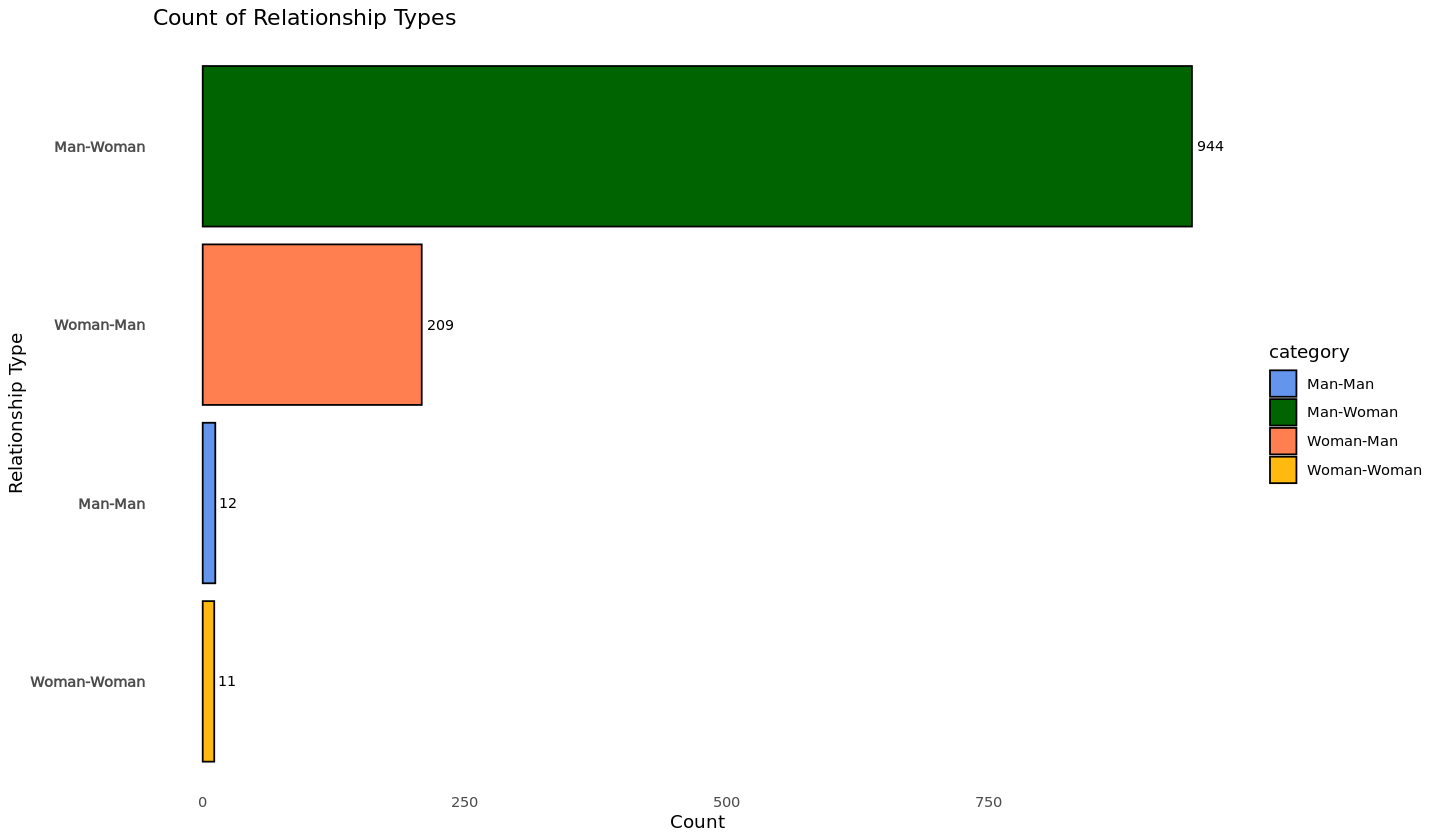

In [25]:
options(repr.plot.res = 120, repr.plot.height = 7, repr.plot.width = 12)

theme_set(theme_light())

grouped_agegaps <- grouped_agegaps %>%
  arrange(desc(count))

category_colors <- c(
  "Man-Woman" = "darkgreen",
  "Woman-Man" = "coral",
  "Woman-Woman" = "darkgoldenrod1",
  "Man-Man" = "cornflowerblue",
  "Other" = "gray"
)

ggplot(grouped_agegaps, aes(x = count, y = fct_reorder(category, count), fill = category)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = count), hjust = -0.2, size = 3, color = "black") +
  scale_fill_manual(values = category_colors) +
  labs(title = "Count of Relationship Types",
       x = "Count",
       y = "Relationship Type") +
  theme_minimal() +
  theme(panel.grid = element_blank(), axis.text.y = element_text(face = "bold"))

## Figure 2: Relationship Types and Age Differences

In [34]:
age_gaps <- age_gaps %>%
  mutate(
    relationship_category = case_when(
      character_1_gender == "man" & character_2_gender == "woman" ~ "Man-Woman",
      character_1_gender == "woman" & character_2_gender == "man" ~ "Woman-Man",
      character_1_gender == "woman" & character_2_gender == "woman" ~ "Woman-Woman",
      character_1_gender == "man" & character_2_gender == "man" ~ "Man-Man",
      TRUE ~ "Other"
    )
  )

In [35]:
# Define the age difference intervals
age_difference_intervals <- c(-Inf, 5, 10, 15, 20, 25, 30, Inf)
age_difference_labels <- c("<5 years", "5-10 years", "11-15 years", "16-20 years", "20-25 years", "26-30 years", "31+ years")

# Add a new column with the grouped age difference
age_gaps <- age_gaps %>%
  mutate(age_difference_group = cut(age_difference, breaks = age_difference_intervals, labels = age_difference_labels, include.lowest = TRUE))

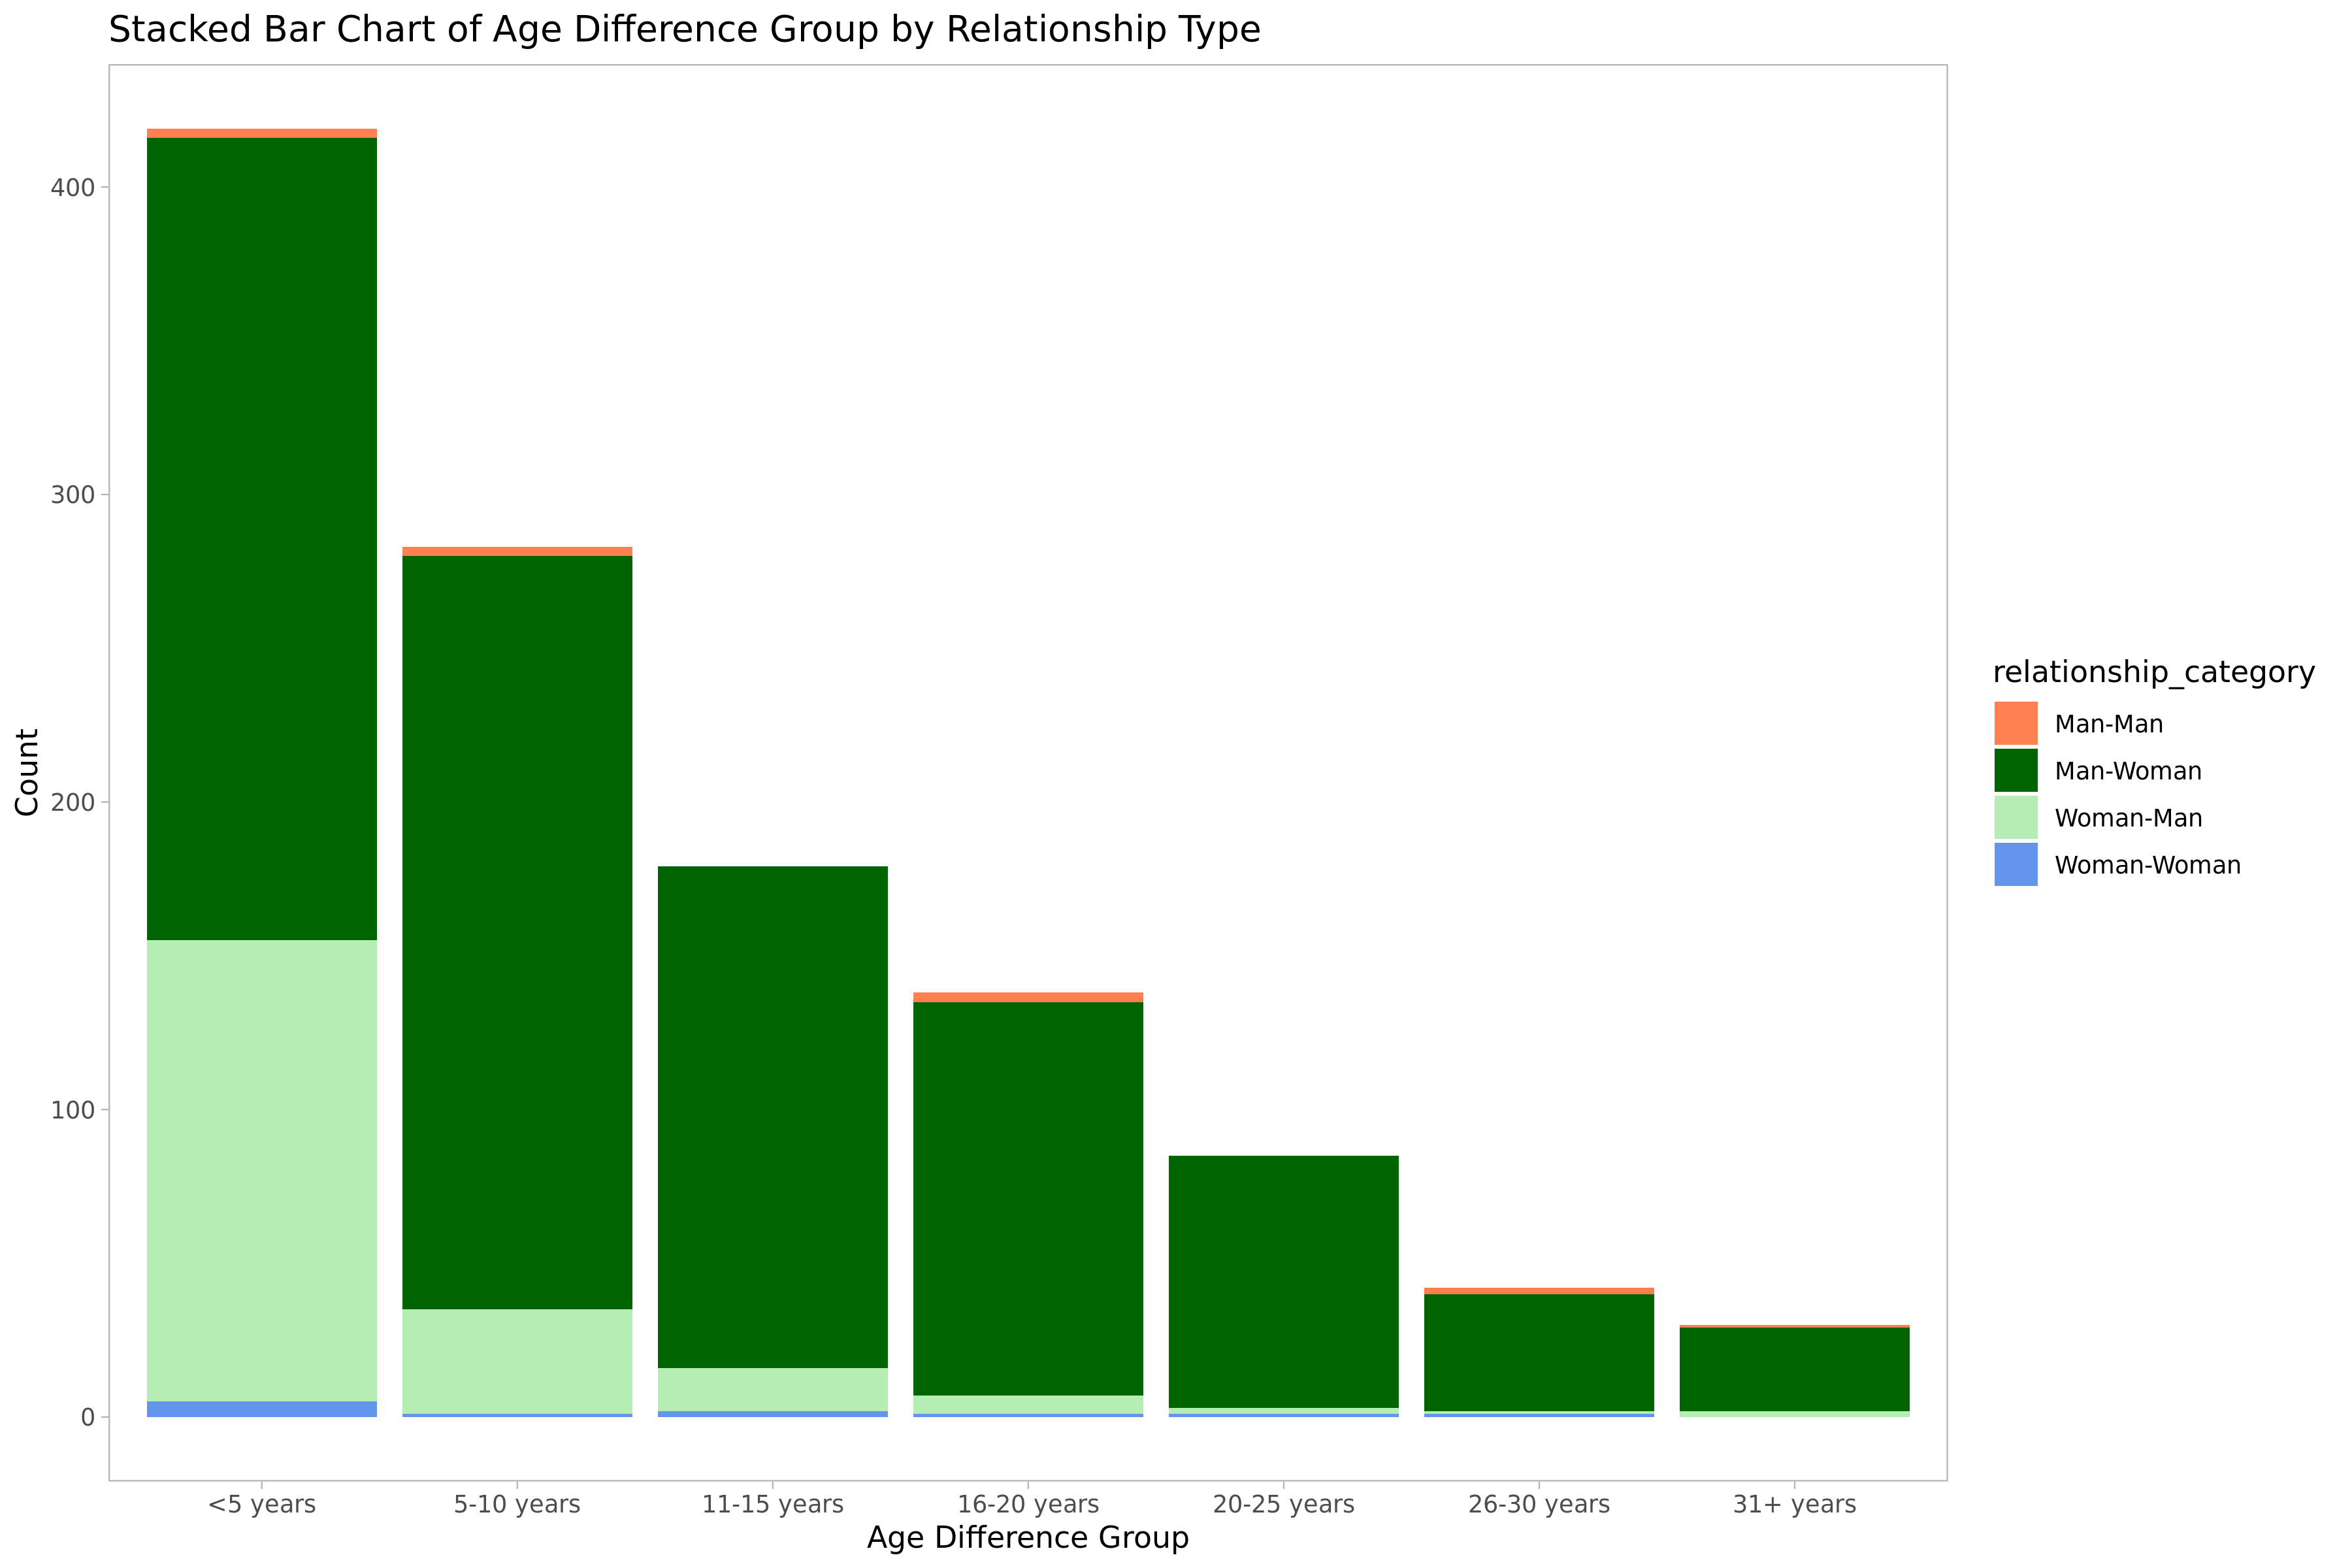

In [70]:
options(repr.plot.res = 300, repr.plot.height = 8, repr.plot.width = 12)

theme_set(theme_light())

custom_colors <- c("coral", "darkgreen", "darkseagreen2", "cornflowerblue")

ggplot(age_gaps, aes(x = age_difference_group, fill = relationship_category)) +
  geom_bar() +
  scale_fill_manual(values = custom_colors) +
  labs(title = "Stacked Bar Chart of Age Difference Group by Relationship Type",
       x = "Age Difference Group",
       y = "Count") +
  theme(panel.grid = element_blank())

## Figure 3: Top 5 Movies with the Highest Age Differences

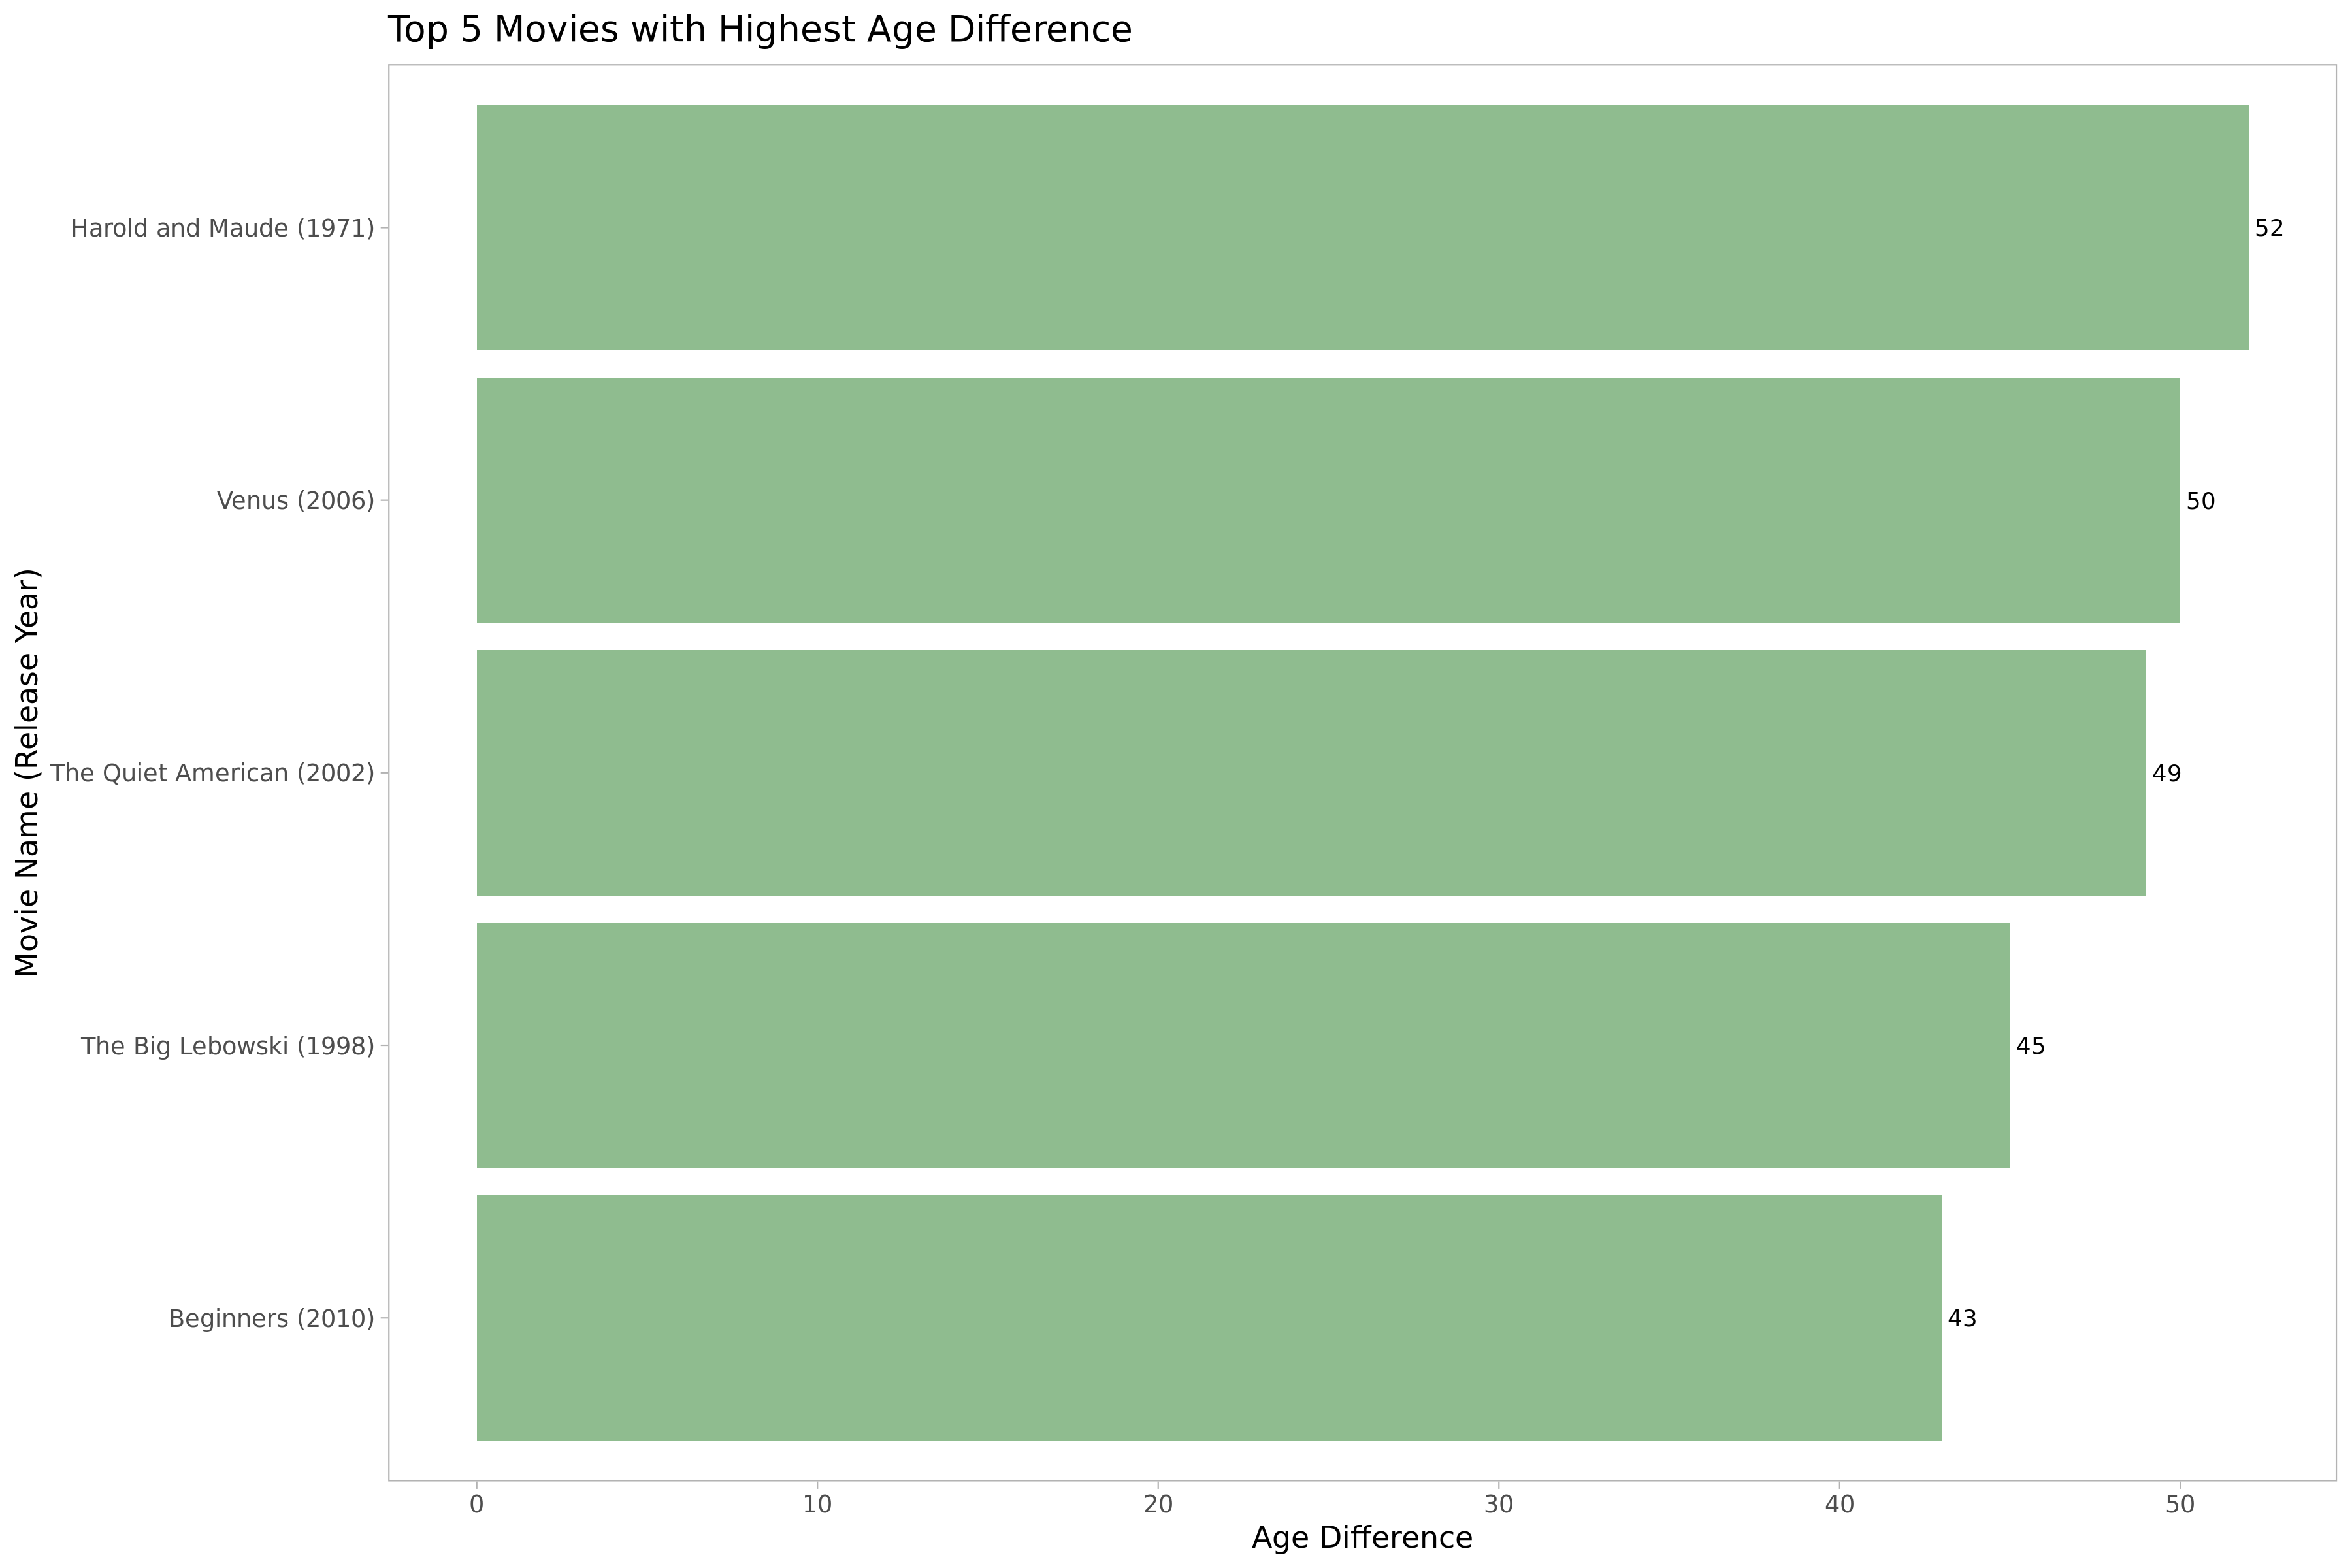

In [71]:
theme_set(theme_light())

top5_age_difference <- age_gaps %>%
  arrange(desc(age_difference)) %>%
  slice_head(n = 5)

ggplot(top5_age_difference, aes(y = reorder(paste0(movie_name, " (", release_year, ")"), age_difference), x = age_difference)) +
  geom_bar(stat = "identity", fill = "darkseagreen") +
    geom_text(aes(label = age_difference), hjust = -0.2, size = 3) +
  labs(title = "Top 5 Movies with Highest Age Difference",
       x = "Age Difference",
       y = "Movie Name (Release Year)") +
  theme(panel.grid = element_blank())

## Narrative
#### The above graphs illustrate Hollywood age gaps. Figure 1 categorizes movies with age gaps into four categories where the first partner listed is the older individual: heterosexual man/woman, heterosexual woman/man, homosexual man/man, and homosexual woman/woman. 944 relationships were between a man and a woman where the man was the older of the two, but there were 209 relationships where the woman was older.

#### Figure 2 goes on to display the categories by age differences that have been grouped into 5-year gap groups. Most relationships depicted had an age gap of less than 5 years. Lastly, the movies with the highest age gaps are depicted in Figure 3. "Harold and Maude" (1971) had the highest age gap of 52 years, followed by "Venus" (2006) with 50 years, "The Quiet American" (2002) with 49 years, "The Big Lebowski" (1998) with 45 years, and "Beginners" (2010) with 43 years. 